In [3]:
# Install SHAP (SHapley Additive exPlanations - A game theoretic approach to explain the output of any machine learning model.)
!pip install shap

In [4]:
# Import all the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

import shap

# Loading 'JS' visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

***Census Income Dataset contains weighted census data extracted from the 1994 and 1995 Current Population Surveys conducted by the U.S. Census Bureau. It is also known as "Adult" dataset.***

***OBJECTIVE:*** Predict whether income exceeds $50K/yr based on census data.

**If labels=0:** The person's income doesn't exceed $50K/yr.

**If labels=1:** The person's income exceeds $50K/yr. 


***Load the Census Income Dataset***

In [5]:
# Getting the data and labels From "SHAP" Datasets.

data, labels = shap.datasets.adult(display = True)

# store the lables as Numpy array.
labels = np.array([ int(label) for label in labels])

# Shape of tha data and lables
print(data.shape, labels.shape)
print(type(data))

(32561, 12) (32561,)
<class 'pandas.core.frame.DataFrame'>


In [6]:
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


*Class labels=0: The person's income doesn't exceed $50K/yr.*

*Class labels=1: The person's income exceeds $50K/yr.*

***Class label count***

**OUTPUT:**  we will see that there is class imbalance.

In [7]:
#Check out the distribution of class labels
pd.Series(labels).value_counts()

0    24720
1     7841
dtype: int64

**Now, we convert the categorical columns with string values to numeric Values. The XGBoost model can handle categorical data natively being a tree-based model so we do not use one-hot encoding.**

In [8]:
# Storing names of all categorical columns in ca_cols.

ca_cols = data.select_dtypes(['category']).columns 
ca_cols

Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [9]:
# Converting the categorical columns into numerical columns

data[ca_cols] = data[ca_cols].apply(lambda y: y.cat.codes) 
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


**Preparing Train and Test datasets**

We will make two datasets:

1. One with the encoded categorical values which will be used for training the model. (x_train, x_test, y_train, y_test)

2. One with the original values which will be used for the model interpretation So, we'll be able to see actual values and not encoded values on the graphs. (x_train_disp, x_test_disp, y_train_disp, y_test_disp)

**For Training purpose - dataset-> 1**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
x_train.head()

(26048, 12) (6513, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
5514,33.0,2,13.0,4,10,1,4,0,0.0,0.0,50.0,39
19777,36.0,4,11.0,2,4,0,4,1,0.0,1887.0,50.0,39
10781,58.0,6,5.0,5,3,1,4,1,0.0,0.0,40.0,39
32240,21.0,4,11.0,2,5,0,4,1,0.0,0.0,46.0,39
9876,27.0,4,10.0,0,8,1,4,1,0.0,0.0,40.0,39


**For model interpretation purpose - dataset-> 2**

In [11]:
data_disp, labels_disp = shap.datasets.adult(display=True)
x_train_disp, x_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.2, random_state=42)
print(x_train_disp.shape, x_test_disp.shape)
x_train_disp.head(3)

(26048, 12) (6513, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
5514,33.0,Local-gov,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,50.0,United-States
19777,36.0,Private,11.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,1887.0,50.0,United-States
10781,58.0,Self-emp-not-inc,5.0,Separated,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States


***Classification Model***

In [12]:
 #importing xgboost model from xgb library

import xgboost as xgb

# Creating a XGB Classifier

xg = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=42) 

**n_estimators:** *The number of trees*

**max_depth:** *Maximum depth of a tree. default=6*

**random_state:** *Used for reproducability.*




In [13]:
# Fit the model

xg.fit(x_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Prediction on the Test dataset**

In [15]:
predictions = xg.predict(x_test)
predictions[:5]

array([0, 1, 1, 0, 0])

**Performance Analysis**

In [16]:
accuracy_score(y_test, predictions)


0.8760939659143252

In [17]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score, plot_roc_curve

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4942
           1       0.78      0.68      0.73      1571

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513



In [18]:
roc_auc_score(y_test, predictions)

0.8089370111498345

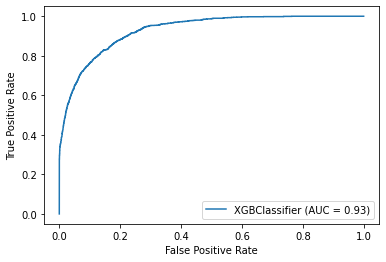

In [19]:
plot_roc_curve(xg, x_test, y_test)

**Model Interpretation -  SHAP**


*SHAP values can explain the output of any machine learning model. SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach.*




> **Explain Predictions**



In [20]:
# creating an explainer for our model
explainer = shap.TreeExplainer(xg)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(x_test)

# Expected value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

pd.DataFrame(shap_values).head()

Expected Value: -1.373216


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.212168,-0.008137,-0.100917,-1.149152,-0.620870,-0.555103,0.003965,-0.370016,-0.135009,-0.035555,-0.583472,0.000820
1,0.414119,-0.223493,-0.471057,0.535323,0.386642,1.117103,0.010701,-0.148373,-0.103117,-0.053731,-0.096136,0.021960
2,-0.427753,0.037533,0.927894,0.352864,0.650141,0.628767,-0.016462,0.052491,-0.168594,-0.084071,0.486537,0.041761
3,-0.400703,0.061546,0.562600,-1.044906,-0.425959,-0.670572,0.025454,-0.320939,-0.143841,-0.049950,-0.245961,0.024486
4,-0.395983,-0.140883,-0.126574,-0.544133,-0.057281,-0.406454,-0.025258,0.111567,-3.746395,-0.033174,0.787953,0.009799


**Expected Value: -1.373216 being displayed above will be used as the base value throughout all the visualizations below. The values above this base value will be put into class 1 (income exceeds 50K/yr) 
where as the values below it will be put into class 0 (income does not exceed 50K/yr).**

**Predicting when a person’s income <= 50K or >= 50K**

In [21]:
y_test_disp[0]

False

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value,
shap_values[0,:], x_test_disp.iloc[0,:])

In [24]:
y_test_disp[2]

True

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value,
shap_values[2,:], x_test_disp.iloc[2,:])

**Visualizing and explaining multiple predictions**

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value,
shap_values[:1000,:], x_test.iloc[:1000,:])

**Feature Importances with SHAP**

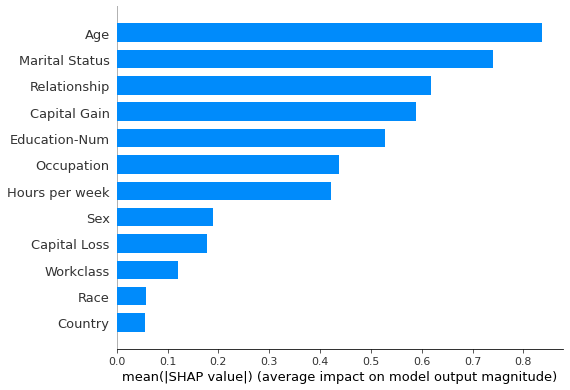

In [30]:
shap.initjs()
shap.summary_plot(shap_values,
x_test, plot_type="bar")

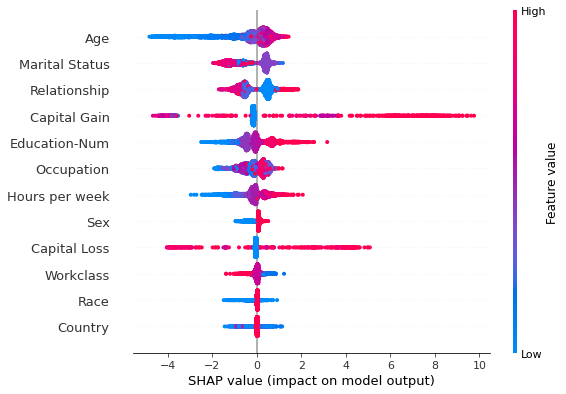

In [32]:
## SUMMARY

shap.initjs()
shap.summary_plot(shap_values, x_test)

**More on this will be uploaded very soon**


In [ ]:
shap.initjs()